In [33]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


Helper functions for preprocessing

In [34]:
def fetch_data(url):
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=";")
    return df

def map_columns(df, columns, mapping):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(mapping)
    return df

def one_hot_encode_columns(df, columns):
    # Check if the specified columns exist in the dataframe
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Apply one-hot encoding to the specified columns
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=False)

    df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    return df_encoded

def encode_cyclic_information(df, column_name, mapping):
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Map the days to numbers
    df[column_name] = df[column_name].map(mapping)
    
    # Create sine and cosine features for cyclic encoding
    df[column_name + '_sin'] = np.sin(2 * np.pi * df[column_name] / 7)
    df[column_name + '_cos'] = np.cos(2 * np.pi * df[column_name] / 7)
    
    # Drop the original day column if you no longer need it
    df = df.drop(columns=[column_name])
    
    return df

def mask_column(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    mask_column_name = f"{column}_unknown"
    
    # Use pd.isna to handle NaN or None
    if pd.isna(mask_value):
        df[mask_column_name] = df[column].apply(lambda x: 1 if pd.isna(x) else 0)
    else:
        df[mask_column_name] = df[column].apply(lambda x: 1 if x == mask_value else 0)
    
    return df

def replace_value_mode(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Create the mask column
    if pd.isna(mask_value):
        mask = df[column].isna()
    else:
        mask = df[column] == mask_value

    # Compute the mode of the column, excluding NaN
    column_mode = df.loc[~mask, column].mode()

    if column_mode.empty:
        raise ValueError(f"Cannot compute mode for column '{column}' as it has no valid values.")

    # Replace masked values with the mode
    df[column] = df[column].where(~mask, column_mode[0])

    return df

def standardize_columns(data, columns):
    scaler = StandardScaler()
    for column in columns : 
        if column in data.columns:
            data[column] = scaler.fit_transform(data[[column]])
    return data

def drop_specific_data(data):
    #Drop the default column (20% is unknown, there are 3/41188 yes)
    #Drop the Pdays column (96.3% unknown)
    #Drop duration, as its for benchmarking not modeling (Supposedly, might want to readd this)

    data = data.drop(columns="default")
    data = data.drop(columns="pdays")
    # data = data.drop(columns="duration")

    #Drop the 5 unknown data entries for now (Might readd later to see if models get more accurate)
    # data = data.drop(columns="nr.employed")
    # data = data.drop(columns="euribor3m")
    # data = data.drop(columns="cons.conf.idx")
    # data = data.drop(columns="emp.var.rate")
    # data = data.drop(columns="cons.price.idx")
    
    return data
    


Helper functions for checking data manipulation validation

In [35]:
def get_unknown_percentage(df):
    unknown_percentages = {}
    unknown_columns_count = 0

    # Loop over each column in the dataframe
    for column in df.columns:
        # Count the occurrences of 'unknown' in the column
        unknown_count = (df[column] == 'unknown').sum()
        
        if(column == "pdays") :
            unknown_count +=(df[column] == 999).sum()
        
        unknown_count +=(df[column].isna()).sum()
        
        # Calculate the percentage of 'unknown' values
        total_count = len(df[column])
        unknown_percentage = (unknown_count / total_count) * 100
        
        # Store the percentage in the dictionary
        unknown_percentages[column] = unknown_percentage
        if unknown_percentage > 0:
            unknown_columns_count +=1
            print(f"{column} unknowns: {unknown_percentage}%")

    if unknown_columns_count == 0:
        print("no Unknowns in the data")
    return unknown_percentages

def get_unknowns_per_row(row):
    return (row == 'unknown').sum()

def count_values(column_name, dataframe):
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return None
    counts = dataframe[column_name].value_counts()
    return counts

url = "https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional-full.csv"
data = fetch_data(url)
print(get_unknown_percentage(data))
print()

for column in data :
    print()
    print(count_values(column, data))

job unknowns: 0.8012042342429834%
marital unknowns: 0.1942313295134505%
education unknowns: 4.202680392347285%
default unknowns: 20.87258424783918%
housing unknowns: 2.40361270272895%
loan unknowns: 2.40361270272895%
pdays unknowns: 96.32174419733903%
{'age': 0.0, 'job': 0.8012042342429834, 'marital': 0.1942313295134505, 'education': 4.202680392347285, 'default': 20.87258424783918, 'housing': 2.40361270272895, 'loan': 2.40361270272895, 'contact': 0.0, 'month': 0.0, 'day_of_week': 0.0, 'duration': 0.0, 'campaign': 0.0, 'pdays': 96.32174419733903, 'previous': 0.0, 'poutcome': 0.0, 'emp.var.rate': 0.0, 'cons.price.idx': 0.0, 'cons.conf.idx': 0.0, 'euribor3m': 0.0, 'nr.employed': 0.0, 'y': 0.0}


age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired        

Preprocessing

In [36]:
binary_mapping = {
    'yes':1,
    'no':0,
    }

education_mapping = {
    'basic.4y':2,
    'basic.6y':3,
    'basic.9y':4,
    'high.school':5,
    'illiterate':1,
    'professional.course':6,
    'university.degree':7,
    'unknown': None
    }

days_mapping = {
        'sun': 0,
        'mon': 1,
        'tue': 2,
        'wed': 3,
        'thu': 4,
        'fri': 5,
        'sat': 6
    }

months_mapping = {
        'jan': 0,
        'feb': 1,
        'mar': 2,
        'apr': 3,
        'may': 4,
        'jun': 5,
        'jul': 6,
        'aug': 7,
        'sep': 8,
        'oct': 9,
        'nov': 10,
        'dec': 11
    }

binary_columns = ["housing", "loan", "y"]
categorical_columns = ["job","marital","contact","poutcome"]
integer_columns = ["age", "balance", "duration", "campaign", "previous"]

def preprocessing(mask_nans = True):
    data = fetch_data(url)
    
    #Remove Duplicate rows
    data = data[~data.duplicated()]

    #Drop necissary features
    data = drop_specific_data(data)

    #Map Binary values to 0,1,NaN
    data = map_columns(data, binary_columns, binary_mapping)

    #Map education to numeric quantities
    data = map_columns(data, ["education"], education_mapping)

    #One hot encode categorical data
    data = one_hot_encode_columns(data, categorical_columns)

    #Perform Cyclical mapping for time data
    data = encode_cyclic_information(data, "day_of_week", days_mapping)
    data = encode_cyclic_information(data, "month", months_mapping)
    
    #Standardize Integer Columns
    data = standardize_columns(data, integer_columns)
    
    if mask_nans :
        #create a mask for housing, loan, education columns
        data = mask_column(data, "housing", None)
        data = mask_column(data, "loan", None)
        data = mask_column(data, "education", None)

        #Imput Housing and Loan to the mode
        data = replace_value_mode(data, "housing", None)
        data = replace_value_mode(data, "loan", None)
        data['education'] = data['education'].fillna(0)
        
    return data


data = preprocessing()

for column in data :
    print(count_values(column, data))
        
print()
print(get_unknown_percentage(data))
    
#NEEDS WORK
#Education Unknowns need to be handled (Currently using -1 with a mask)
#Need to decide what should be standardized, currently every integer is

#Currently WIP
#Create a different preprocessing type to be used with Models that can handle Unknowns, where NaN replaces unknown
#IE Random forests with surrogate splits etc
#Currently setup so mask_nans can be = False and it will return a dataset with binary values that have NaN

age
-0.865962    1947
-0.769998    1845
-0.674033    1833
-0.386141    1779
-0.482105    1758
             ... 
 4.699962       2
 4.891890       2
 5.179782       1
 4.508033       1
 5.275747       1
Name: count, Length: 78, dtype: int64
education
7.0    12164
5.0     9512
4.0     6045
6.0     5240
2.0     4176
3.0     2291
0.0     1730
1.0       18
Name: count, dtype: int64
housing
1.0    22561
0.0    18615
Name: count, dtype: int64
loan
0.0    34928
1.0     6248
Name: count, dtype: int64
duration
-0.649111    170
-0.668393    170
-0.471711    168
-0.714671    167
-0.517990    163
            ... 
 5.054659      1
 3.064703      1
 3.874569      1
 3.512058      1
 6.207754      1
Name: count, Length: 1544, dtype: int64
campaign
-0.565963     17634
-0.204990     10568
 0.155984      5340
 0.516958      2650
 0.877932      1599
 1.238905       979
 1.599879       629
 1.960853       400
 2.321827       283
 2.682800       225
 3.043774       177
 3.404748       125
 3.765722        9

In [37]:
def split_data(df):
    y = df['y']
    X = df.drop(columns=['y'])
    return X, y

In [38]:
preprocessed_data = preprocessing()
X, y = split_data(data)

over_strength = 0.2
under_strength = 0.5
over = SMOTE(sampling_strategy=over_strength, random_state=42)
under = RandomUnderSampler(sampling_strategy=under_strength, random_state=42)

#Create Train-TestSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Handling Imbalance styles
#Get Over resample sets
X_over_resample, y_over_resample = over.fit_resample(X_train, y_train)

#Get Under Resample sets
X_under_resample, y_under_resample = under.fit_resample(X_train, y_train)

#Use class weight adjustments in SVM, Logicistic Regression, Random Forest

#Use a balanced Random Forest

Model types to make

SVM 
Linear Regression
Logistic Regression
Gradient Boosting
Random Forest
Decision tree
Bagging

Most likely usefull models
Logistic Regression
Random Forest


Confusion Matrix:
[[6188 1120]
 [  39  889]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7308
           1       0.44      0.96      0.61       928

    accuracy                           0.86      8236
   macro avg       0.72      0.90      0.76      8236
weighted avg       0.93      0.86      0.88      8236

ROC AUC Score: 0.95
Precision-Recall AUC: 0.64


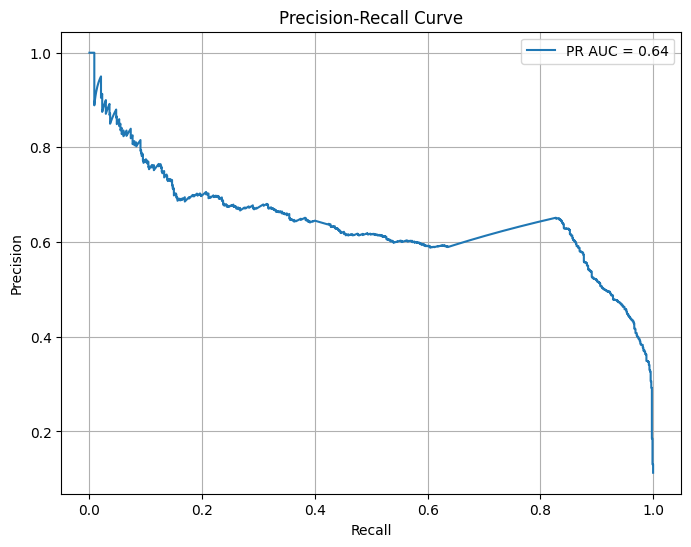

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Assume X and y are preprocessed features and labels
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights for imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define the SVM model
svm_model = SVC(kernel='rbf', class_weight=class_weights_dict, probability=True, random_state=42, C=10, gamma=0.01)


# Best model and parameters
best_model = svm_model

# Make predictions using the best model
best_model.fit(X, y)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute and display ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Compute and plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [40]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

#Accuracy is not a good metric on imbalanced data sets, still display it but also calculate
# Precision, Recall, and F1-Score: These metrics give a better understanding of the model’s performance on the minority class.
# ROC-AUC: Measures how well the model distinguishes between the two classes, even in imbalanced scenarios.
# Precision-Recall AUC: This is especially useful when the dataset is highly imbalanced, as it focuses on the performance on the minority class.

#THIS IS AN EXAMPLE OF METRICS, STILL NEEDS MODELS
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])



NameError: name 'model' is not defined